In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import scipy.stats as stat
import random
import diff_classifier.aws as aws
import diff_classifier.msd as msd
from diff_classifier.msd import binning, precision_weight, precision_averaging, plot_all_experiments
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [2]:
folder = '08_03_18_new_gel_validation'
bucket = 'hpontes.data'
experiment = 'NH2-PEG' #Used for naming purposes. Should exclude XY and well information

vids = 20
to_track = []
wells = 4
frames = 651
fps = 100.02

In [ ]:
to_track

In [11]:
slices = ["1", "2", "3", "4", "5"]#Number of slices per pup
well = ['1', '2', '3', '4']
folder = '08_03_18_new_gel_validation' #Folder in AWS S3 containing files to be analyzed

for i in slices:
    for j in well:
        to_track.append('NH2-PEG_t{}_XY{}'.format(j, i))

slices, bins, well_names = binning(to_track)
geoM2xy = {}
gSEM = {}
for sample_name in to_track:
    aws.download_s3('{}/geomean_{}.csv'.format(folder, sample_name), 'geomean_{}.csv'.format(sample_name), bucket_name=bucket)
    aws.download_s3('{}/geoSEM_{}.csv'.format(folder, sample_name), 'geoSEM_{}.csv'.format(sample_name), bucket_name=bucket)
    geoM2xy[sample_name] = np.genfromtxt('geomean_{}.csv'.format(sample_name))
    gSEM[sample_name] = np.genfromtxt('geoSEM_{}.csv'.format(sample_name))
    print(sample_name)
    #msd_f = 'msd_{}.csv'.format(sample_name)
    #aws.download_s3('{}/{}'.format(folder, msd_f), msd_f, bucket_name=bucket)
    #try:
    #    geoM2xy[sample_name], gSEM[sample_name] = msd.gavg_MSDs(sample_name, umppx=0.07, fps=100.02, upload=True, remote_folder=folder, bucket=bucket)
    #except:
    #    geoM2xy[sample_name], gSEM[sample_name] = (np.nan*np.ones(frames), np.nan*np.ones(frames))

for key in gSEM:
    gSEM[key][gSEM[key]==0]=np.nan
    geoM2xy[key][geoM2xy[key]==0]=np.nan
    

In [ ]:
#Run this is you aren't doing two cycles of averaging e.g. first over videos then over wells.

weights = precision_weight(to_track, gSEM)
geo, gS = precision_averaging(to_track, geoM2xy, gSEM, weights, bucket=bucket, folder=folder, experiment=experiment)

In [12]:
geo_slices = {}
gSEM_slices = {}

w_slices = {}
wo_slices = {}

for key in bins:
    wo_slices[key] = precision_weight(bins[key], gSEM)
    geo_slices[key], gSEM_slices[key] = precision_averaging(bins[key], geoM2xy, gSEM, wo_slices[key]) 

for key in geo_slices:
    geo_slices[key][geo_slices[key]==0]=np.nan
    gSEM_slices[key][gSEM_slices[key]==0]=np.nan

/home/ubuntu/source/diff-classifier/diff_classifier/msd.py:583: RuntimeWarning: Mean of empty slice
  weights = slices*np.nanmean(w_holder, axis=0)
/home/ubuntu/source/diff-classifier/diff_classifier/msd.py:626: RuntimeWarning: Mean of empty slice
  geo = slices*np.nanmean(geo_holder, axis=0)
/home/ubuntu/source/diff-classifier/diff_classifier/msd.py:627: RuntimeWarning: Mean of empty slice
  gSEM = np.sqrt((1/(slices*np.nanmean(gSEM_holder, axis=0))))


In [13]:
weights = precision_weight(well_names, gSEM_slices)
geo, gS = precision_averaging(well_names, geo_slices, gSEM_slices, weights, bucket=bucket, folder=folder, experiment=experiment)

/home/ubuntu/source/diff-classifier/diff_classifier/msd.py:583: RuntimeWarning: Mean of empty slice
  weights = slices*np.nanmean(w_holder, axis=0)
/home/ubuntu/source/diff-classifier/diff_classifier/msd.py:626: RuntimeWarning: Mean of empty slice
  geo = slices*np.nanmean(geo_holder, axis=0)
/home/ubuntu/source/diff-classifier/diff_classifier/msd.py:627: RuntimeWarning: Mean of empty slice
  gSEM = np.sqrt((1/(slices*np.nanmean(gSEM_holder, axis=0))))


Text(0,0.5,'Mean Squared Displacement ($\\mu$m$^2$/s)')

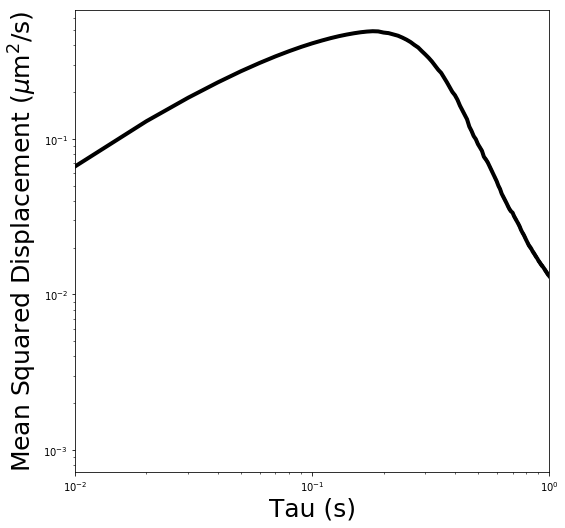

In [14]:
#Plot as desired. Can also modift to include multiple datasets as needed. Yay!
#Example plot

fig = plt.figure(figsize=(8.5, 8.5))
y_range = 1
plt.xlim(10**-2, 10**0)
#plt.ylim(0, y_range)

x = np.linspace(0, frames-1, frames)/fps

plt.loglog(x, np.exp(geo), 'k', linewidth=4)
plt.loglog(x, np.exp(geo - 1.96*gS), 'k--', linewidth=2)
plt.loglog(x, np.exp(geo + 1.96*gS), 'k--', linewidth=2)

plt.xlabel('Tau (s)', fontsize=25)
plt.ylabel(r'Mean Squared Displacement ($\mu$m$^2$/s)', fontsize=25)

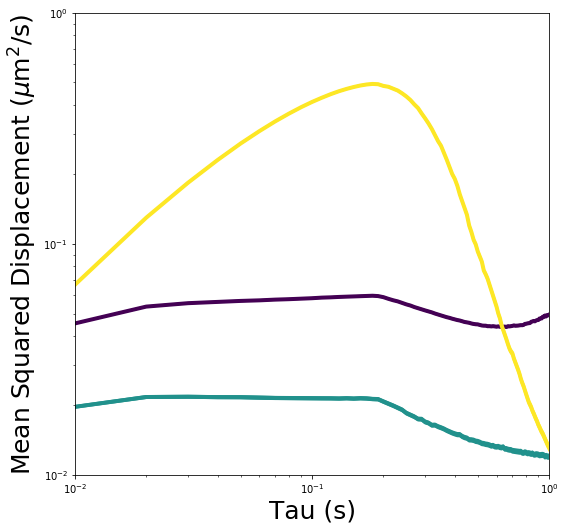

In [17]:
to_plot_f = ['COOH', 'NH2', 'NH2-PEG']
plot_all_experiments(to_plot_f, bucket=bucket, folder=folder, yr=(10**-2, 10**0))

In [ ]:
plot_all_experiments()

In [ ]:
for key in geo_slices:
    print(key)